In [102]:
"""
Extend the 1D case from https://github.com/udemirezen/PINN-1 to the 2D heat diffusion
"""

import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [103]:
import numpy as np

# diffusion parameter
D = 0.1

In [104]:
"""
Number of inputs and outputs: #inputs = 3 (x,y,t); #outputs = 1 (u)

This NN has 5 hidden layer with 5 neurons each
"""
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.hidden_layer1 = nn.Linear(3,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self,x,y,t):
        inputs = torch.cat([x,y,t],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output
        

In [105]:
# create a nn model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [106]:
# the heat equation
def f(x,y,t,net):
    u = net(x,y,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t - D*(u_xx + u_yy)
    return pde

In [107]:
nb = 10 # number of points along each boundary
def gen_boundarypts():
    x_bc,y_bc,u_bc,t_bc = np.zeros((2000,1)),np.zeros((2000,1)),np.zeros((2000,1)),np.zeros((2000,1))
    t_points = np.random.uniform(low=0.0, high=1.0, size=(50,1))
    for i,t in enumerate(t_points):
        t_bc[i*4*nb:(i+1)*4*nb,0] = np.full((4*nb,),t)
        # below code assigns 40 points at each timestep

        # top boundary is prescribed as a finite value
        #x_bc[i*4*nb:(i*4+1)*nb,0] = np.random.uniform(low=-0.5, high=0.5, size=(10,)) # x coordinate
        x_bc[i*4*nb:(i*4+1)*nb,0] = np.linspace(-0.5,0.5,nb)
        y_bc[i*4*nb:(i*4+1)*nb,0] = np.full((nb,),0.5) # y coordinate
        u_bc[i*4*nb:(i*4+1)*nb,0] = np.full((nb,),1.0) # fixed temperature value
        # bottom
        #x_bc[(i*4+1)*nb:(i*4+2)*nb,0] = np.random.uniform(low=-0.5, high=0.5, size=(10,)) # x coordinate
        x_bc[(i*4+1)*nb:(i*4+2)*nb,0] = np.linspace(-0.5,0.5,nb)
        y_bc[(i*4+1)*nb:(i*4+2)*nb,0] = np.full((nb,),-0.5) # y coordinate
        # left
        x_bc[(i*4+2)*nb:(i*4+3)*nb,0] = np.full((nb,),-0.5) # x coordinate
        #y_bc[(i*4+2)*nb:(i*4+3)*nb,0] = np.random.uniform(low=-0.5, high=0.5, size=(10,)) # y coordinate
        y_bc[(i*4+2)*nb:(i*4+3)*nb,0] = np.linspace(-0.5,0.5,nb)
        # right
        x_bc[(i*4+3)*nb:(i*4+4)*nb,0] = np.full((nb,),0.5) # x coordinate
        #y_bc[(i*4+3)*nb:(i*4+4)*nb,0] = np.random.uniform(low=-0.5, high=0.5, size=(10,)) # y coordinate
        y_bc[(i*4+3)*nb:(i*4+4)*nb,0] = np.linspace(-0.5,0.5,nb)
    return x_bc,y_bc,u_bc,t_bc

In [108]:
np.linspace(-0.5,0.5,10)

array([-0.5       , -0.38888889, -0.27777778, -0.16666667, -0.05555556,
        0.05555556,  0.16666667,  0.27777778,  0.38888889,  0.5       ])

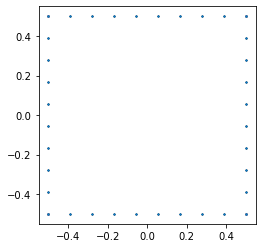

In [109]:
# obtain training data from initial boundary conditions
# initial condition: u = 0 at t = 0
x_ic = np.random.uniform(low=-0.5, high=0.5, size=(200,1))
y_ic = np.random.uniform(low=-0.5, high=0.5, size=(200,1))
t_ic = np.zeros((200,1))
u_ic = np.zeros((200,1))

# boundary condition: u_top = 1; else boundary = 0
# time: t = 0~1
x_bc,y_bc,u_bc,t_bc = gen_boundarypts()

x_ibc = np.concatenate((x_ic,x_bc),axis=0)
y_ibc = np.concatenate((y_ic,y_bc),axis=0)
t_ibc = np.concatenate((t_ic,t_bc),axis=0)
u_ibc = np.concatenate((u_ic,u_bc),axis=0)

# plot boundary points
import matplotlib.pyplot as plt

plt.Figure()
plt.scatter(x_bc,y_bc,s=0.2)
axes=plt.gca()
axes.set_aspect(1)

In [110]:
# actural training of the nn model
iterations = 20000
previous_validation_loss = 99999999.0
loss_data = []
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # loss based on initial boundary conditions
    pt_x_ibc = Variable(torch.from_numpy(x_ibc).float(), requires_grad=False).to(device)
    pt_y_ibc = Variable(torch.from_numpy(y_ibc).float(), requires_grad=False).to(device)
    pt_t_ibc = Variable(torch.from_numpy(t_ibc).float(), requires_grad=False).to(device)
    pt_u_ibc = Variable(torch.from_numpy(u_ibc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_ibc,pt_y_ibc,pt_t_ibc)
    mse_u = mse_cost_function(net_bc_out,pt_u_ibc)

    # loss based on PDE
    x_collocation = np.random.uniform(low=-0.5, high=0.5, size=(2200,1))
    y_collocation = np.random.uniform(low=-0.5, high=0.5, size=(2200,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(2200,1))
    all_zeros = np.zeros((2200,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation,pt_y_collocation,pt_t_collocation,net)
    mse_f = mse_cost_function(f_out,pt_all_zeros)

    # combining the loss function
    loss = mse_u + mse_f

    loss.backward() # computing gradients using backward propagation
    optimizer.step()

    with torch.autograd.no_grad():
        print(epoch,"Training Loss:",loss.data)
        loss_data.append(loss.data.item())

0 Training Loss: tensor(0.4561)
1 Training Loss: tensor(0.4512)
2 Training Loss: tensor(0.4463)
3 Training Loss: tensor(0.4414)
4 Training Loss: tensor(0.4367)
5 Training Loss: tensor(0.4319)
6 Training Loss: tensor(0.4272)
7 Training Loss: tensor(0.4226)
8 Training Loss: tensor(0.4180)
9 Training Loss: tensor(0.4135)
10 Training Loss: tensor(0.4091)
11 Training Loss: tensor(0.4046)
12 Training Loss: tensor(0.4003)
13 Training Loss: tensor(0.3960)
14 Training Loss: tensor(0.3918)
15 Training Loss: tensor(0.3876)
16 Training Loss: tensor(0.3835)
17 Training Loss: tensor(0.3794)
18 Training Loss: tensor(0.3754)
19 Training Loss: tensor(0.3715)
20 Training Loss: tensor(0.3676)
21 Training Loss: tensor(0.3638)
22 Training Loss: tensor(0.3600)
23 Training Loss: tensor(0.3563)
24 Training Loss: tensor(0.3527)
25 Training Loss: tensor(0.3491)
26 Training Loss: tensor(0.3455)
27 Training Loss: tensor(0.3421)
28 Training Loss: tensor(0.3386)
29 Training Loss: tensor(0.3353)
30 Training Loss: te

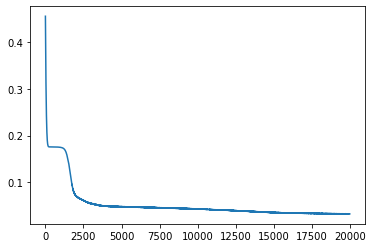

In [114]:
plt.plot(loss_data)

In [111]:
# Save Model
torch.save(net.state_dict(), "heat_model.pt")

In [112]:
x = np.arange(-0.5,0.5,0.01)
y = np.arange(-0.5,0.5,0.01)
t = np.arange(0.0,1.0,0.1)
ms_xx, ms_yy, ms_tt = np.meshgrid(x,y,t)
x = np.ravel(ms_xx).reshape(-1,1)
y = np.ravel(ms_yy).reshape(-1,1)
t = np.ravel(ms_tt).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_y = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device) 
pt_u = net(pt_x,pt_y,pt_t)
u = pt_u.data.cpu().numpy()
ms_uu = u.reshape(ms_xx.shape)

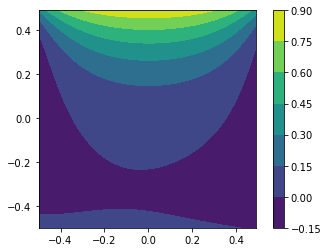

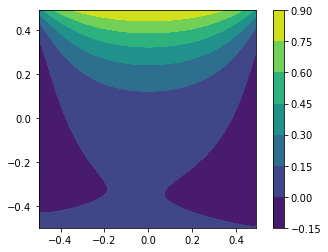

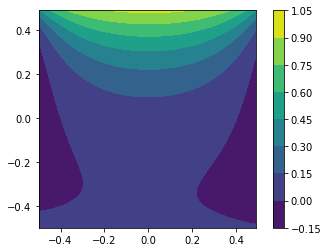

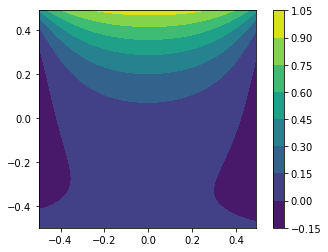

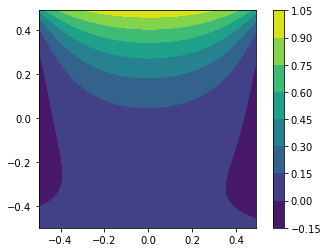

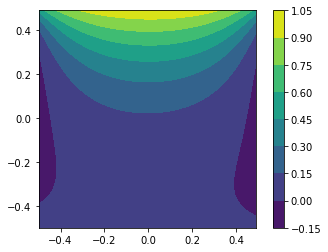

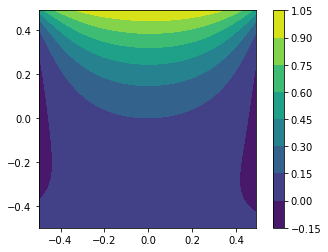

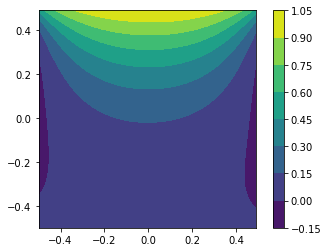

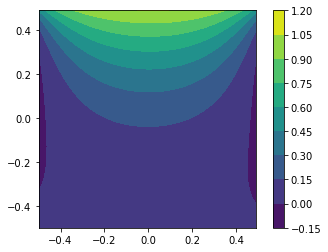

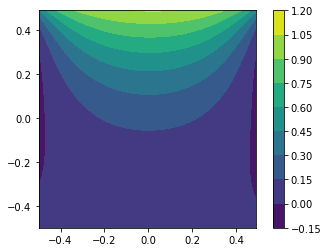

In [113]:
for i in range(10):
    fig = plt.figure()
    plt.contourf(np.arange(-0.5,0.5,0.01),np.arange(-0.5,0.5,0.01),ms_uu[:,:,i])
    plt.axis('scaled')
    plt.colorbar()